In [1]:
from data_utils import clean_html, Embedder, load_data
data = load_data("data")

title_embedding_dim = 32
body_embedding_dim = 32
post_links = data["PostLinks"]
posts = data["Posts"][data["Posts"]["posttypeid"] == "1"]
users = data["Users"]
votes = data["Votes"]
tags = data["Tags"]
comments = data["Comments"]

# Feature Engineering
# 1. Extract features from Posts
posts_features = ['id', 'score', 'viewcount', 'answercount', 'commentcount']
posts_features.extend(["body", "title"])
posts_features = posts[posts_features]
posts_features['body'] = posts_features['body'].map(clean_html)
posts_features = posts_features.rename(columns={'id': 'postid'})

# 2. Extract features from Users
users_features = users[['id', 'reputation', 'views', 'upvotes', 'downvotes']]
users_features = users_features.rename(columns={'id': 'userid'})

# 3. Aggregate Votes
votes_agg = votes.groupby('postid').agg({'votetypeid': 'count'}).reset_index()
votes_agg = votes_agg.rename(columns={'votetypeid': 'vote_count'})

# 4. Aggregate Comments
comments_agg = (
    comments.astype({"score": "int32", "id": "int32"})
    .groupby('postid')
    .agg({'score': 'mean', 'id': 'count'})
    .reset_index()
    .rename(columns={'score': 'avg_comment_score', 'id': 'comment_count'})
)

pooled_text = comments.groupby('postid')['text'].apply(lambda x: ' '.join(x)).reset_index()
pooled_text = pooled_text.rename(columns={'text': 'comments_text'})
comments_agg = comments_agg.merge(pooled_text, on='postid', how='left')

# Generate negative examples
# Get all unique post IDs
post_ids = posts['id'].unique()

# Create a set of existing links for quick lookup
existing_links = set(zip(post_links['postid'], post_links['relatedpostid']))

# Label positive examples as 1
df = posts_features.copy()

df2 = df.merge(votes_agg, on='postid', how='left')
df2 = df2.merge(comments_agg, on='postid', how='left')
df2 = df2[df2["body"].isnull() == False]

/tmp/ipykernel_313903/2836599742.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_features['body'] = posts_features['body'].map(clean_html)


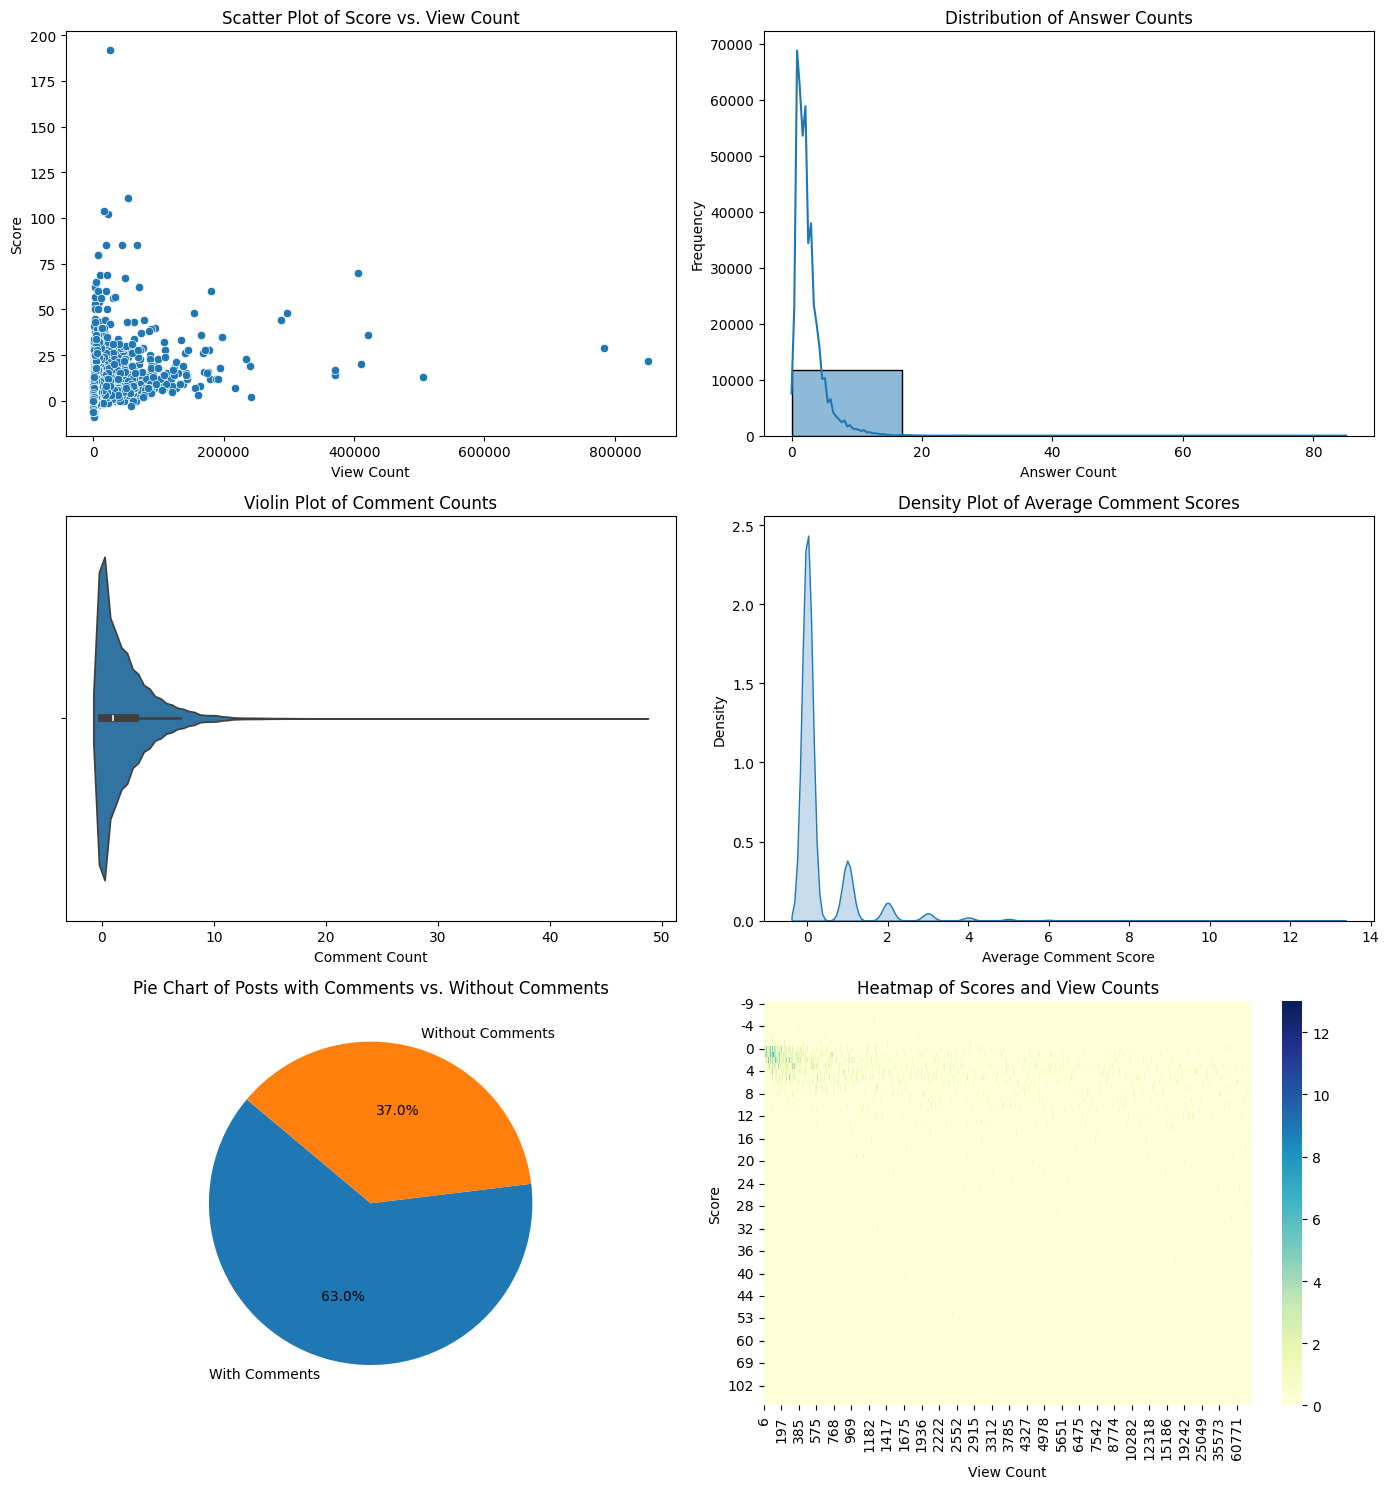

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = df2
for col in ["viewcount", "score", "answercount", "commentcount", "avg_comment_score"]:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)


# Set up the matplotlib figure
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Plot 1: Scatter Plot of Score vs. View Count
sns.scatterplot(x='viewcount', y='score', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Scatter Plot of Score vs. View Count')
axes[0, 0].set_xlabel('View Count')
axes[0, 0].set_ylabel('Score')

# Plot 2: Histogram of Answer Counts
sns.histplot(df['answercount'], bins=5, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Answer Counts')
axes[0, 1].set_xlabel('Answer Count')
axes[0, 1].set_ylabel('Frequency')

# Plot 3: Violin Plot of Comment Counts
sns.violinplot(x='commentcount', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Violin Plot of Comment Counts')
axes[1, 0].set_xlabel('Comment Count')

# Plot 4: Density Plot of Average Comment Scores
sns.kdeplot(df['avg_comment_score'].dropna(), ax=axes[1, 1], fill=True)
axes[1, 1].set_title('Density Plot of Average Comment Scores')
axes[1, 1].set_xlabel('Average Comment Score')

# Plot 5: Pie Chart of Posts with Comments vs. Without Comments
comment_presence = df['commentcount'] > 0
comment_labels = ['With Comments', 'Without Comments']
comment_sizes = [comment_presence.sum(), len(df) - comment_presence.sum()]
axes[2, 0].pie(comment_sizes, labels=comment_labels, autopct='%1.1f%%', startangle=140)
axes[2, 0].set_title('Pie Chart of Posts with Comments vs. Without Comments')

# Plot 6: Heatmap of Scores and View Counts
heatmap_data = df.pivot_table(index='score', columns='viewcount', aggfunc='size', fill_value=0)
sns.heatmap(heatmap_data, cmap='YlGnBu', ax=axes[2, 1])
axes[2, 1].set_title('Heatmap of Scores and View Counts')
axes[2, 1].set_xlabel('View Count')
axes[2, 1].set_ylabel('Score')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [17]:
fig.savefig("images/eda.png")